In [58]:
import os
import torch
import torchvision
import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils
from torchvision.utils import make_grid,save_image
from torchvision.datasets import ImageFolder
from IPython.display import Image
import torchvision.transforms as tt
from torch.utils.data import DataLoader
from torchvision.utils import make_grid,save_image

  ##  Dataset Acquisition

We will be using 2 datasets totalling 30000 images

1. **Pokemon_V2 Dataset (kaggle)**

  9002 images from kaggle hub dataset (pokemon v2 , containing augmented images of original 813 images form v1 dataset)
  
  Link: https://www.kaggle.com/datasets/rajatvisitme/pokemon-image-dataset-v2

  the original 813 images are acquired from https://veekun.com/dex/downloads

2. **Pokemon Generation One - 20,100 Gen 1 Pokémon (kaggle)**

  20000 images being a combination of multiple existing datasets - All 151 Pokemon sorted by name

  Link: https://www.kaggle.com/datasets/bhawks/pokemon-generation-one-22k/data


In [59]:
dataset1_path = "/kaggle/input/pokemon-image-dataset-v2"
dataset2_path = "/kaggle/input/pokemon-generation-one-22k"

# Verify paths
print(f"Dataset 1 path: {dataset1_path}")
print(f"Dataset 2 path: {dataset2_path}")

# Check if paths exist
if not os.path.exists(dataset1_path):
    raise FileNotFoundError(f"Dataset 1 path does not exist: {dataset1_path}")
if not os.path.exists(dataset2_path):
    raise FileNotFoundError(f"Dataset 2 path does not exist: {dataset2_path}")

Dataset 1 path: /kaggle/input/pokemon-image-dataset-v2
Dataset 2 path: /kaggle/input/pokemon-generation-one-22k


In [60]:
# Checkpoint directory
checkpoint_dir = "/kaggle/working/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)  #overrride creation if it doesnt exist

# Image directory
image_dir = "/kaggle/working/images"
os.makedirs(image_dir, exist_ok=True)  

# Animation file
animation_file = "/kaggle/working/animation.html"
os.makedirs(animation_file, exist_ok=True) 

# Define the directory path
save_dir = '/kaggle/working/models'
os.makedirs(save_dir, exist_ok=True) 

In [61]:
image_size = 64
batch_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [62]:
train_dataset = ImageFolder(dataset1_path,transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    tt.RandomHorizontalFlip(p=0.5)
]))

In [63]:
train_dataloader = DataLoader(train_dataset,
                              batch_size,
                              shuffle=True,
                              num_workers=3,
                              pin_memory=True)

In [64]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [65]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

In [66]:
def show_images_grid(dataloader, num_images=28):
    # get batch of data
    data_iter = iter(dataloader)
    batch = next(data_iter)  # Get the batch (could be a tuple or list)
    
    # Unpack the batch (assuming it returns (images, labels))
    if isinstance(batch, (list, tuple)):
        images = batch[0]  # Extract images from the batch
    else:
        images = batch  # If batch is already a tensor, use it directly
    
    # Ensure we don't exceed the number of images in the batch
    num_images = min(num_images, images.size(0))
    
    # Create a grid of images
    grid = make_grid(images[:num_images], nrow=7, normalize=True, padding=2)
    
    # Convert the grid to a numpy array and change the order of dimensions
    grid = grid.permute(1, 2, 0).cpu().numpy()  # Move to CPU and convert to NumPy
    
    # Display the grid using matplotlib
    plt.figure(figsize=(16, 12))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

### preview of oringinal dataset that we are working with

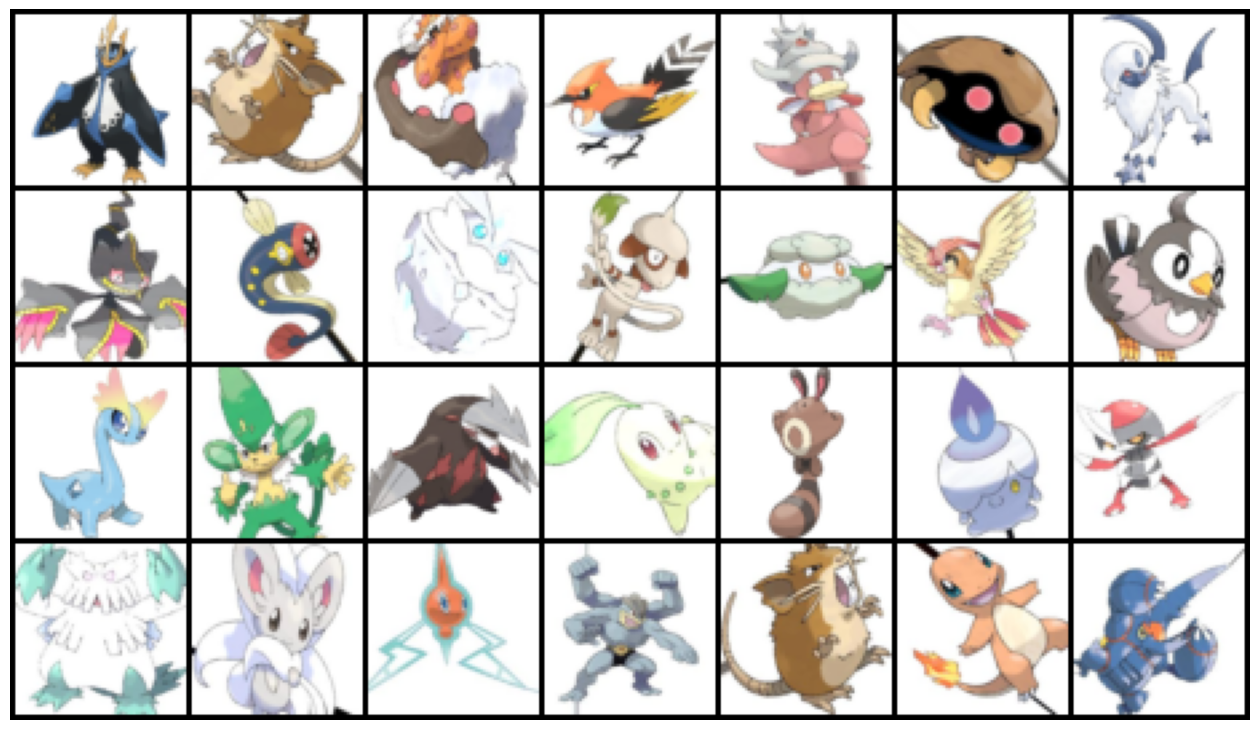

In [67]:
show_images_grid(train_dataloader)

In [68]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,device)
    def __len__(self):
        return len(self.dl)

In [69]:
device = get_default_device()
device

device(type='cuda')

In [70]:
train_dataloader = DeviceDataLoader(train_dataloader, device)

### Creating dcgan architecture

In [71]:
discriminator = nn.Sequential(
    nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2,inplace=True),
    
    nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2,inplace=True),
    
    nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2,inplace=True),
    
    nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2,inplace=True),
    
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    
    nn.Flatten(),
    nn.Sigmoid()
)

In [72]:
discriminator = to_device(discriminator,device)

In [73]:
latent_dim = 128
generator = nn.Sequential(
    nn.ConvTranspose2d(latent_dim,512,kernel_size=4,stride=1,padding=0,bias = False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1,bias = False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1,bias = False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1,bias = False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias = False),
    nn.Tanh()
)

In [74]:
generator = to_device(generator,device)

In [75]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_dim, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [76]:
def train_generator(opt):
    opt.zero_grad() # clearing gradietns
    latent = torch.randn(batch_size,latent_dim,1,1,device=device)
    fake_images = generator(latent)
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size,1,device = device)
    loss = F.binary_cross_entropy(preds,targets)
    loss.backward()
    opt.step()
    return loss.item()

In [77]:
fixed_latent = torch.randn(64, latent_dim, 1, 1, device=device)

In [78]:
def save_imagesSamp(index, latent_tensors):
    fake_images = generator(latent_tensors)
    fake_fname = 'generatedPokemon-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(image_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)

In [79]:
save_imagesSamp(0, fixed_latent)

Saving generatedPokemon-images-0000.png


In [80]:
def save_checkpoint(epoch, generator, discriminator, optimizerG, optimizerD, checkpoint_dir, filename="checkpoint.pth"):
    # Create the checkpoint directory if it doesn't exist
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Prepare the checkpoint dictionary
    checkpoint = {
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'optimizerG_state_dict': optimizerG.state_dict(),
        'optimizerD_state_dict': optimizerD.state_dict(),
    }

    # Save the checkpoint
    checkpoint_path = os.path.join(checkpoint_dir, filename)
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch} to {checkpoint_path}")

def load_checkpoint(checkpoint_path, generator, discriminator, optimizerG=None, optimizerD=None):

    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Load model states
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])

    # Load optimizer states (if provided)
    if optimizerG is not None:
        optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])
    if optimizerD is not None:
        optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])

    # Load additional metadata
    epoch = checkpoint['epoch']
    loss_history = checkpoint['loss_history']

    print(f"Checkpoint loaded from epoch {epoch}")
    return epoch, loss_history

In [81]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()   # clearing the cache for working prior gpu
    
    # Losses & scores to be stored in empty tuple lists
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers enforced by adams optimisr, learning rate is 0.0002 for now , gives most stable training
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dataloader):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        if (epoch + 1) % 10 == 0:
            save_checkpoint(epoch + 1, generator, discriminator, opt_g, opt_d, checkpoint_dir, filename=f"checkpoint_epoch_{epoch + 1}.pth")
  
        # Save generated images
        save_imagesSamp(epoch+start_idx, fixed_latent)
    
    return losses_g, losses_d, real_scores, fake_scores

In [82]:
lr = 0.0002 
epochs = 450
history = fit(epochs, lr)

  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [1/450], loss_g: 2.8725, loss_d: 0.7848, real_score: 0.7928, fake_score: 0.3968
Saving generatedPokemon-images-0001.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [2/450], loss_g: 1.7286, loss_d: 0.5795, real_score: 0.6771, fake_score: 0.1380
Saving generatedPokemon-images-0002.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [3/450], loss_g: 2.3413, loss_d: 0.6241, real_score: 0.6100, fake_score: 0.0607
Saving generatedPokemon-images-0003.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [4/450], loss_g: 2.8993, loss_d: 0.4397, real_score: 0.7949, fake_score: 0.1678
Saving generatedPokemon-images-0004.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [5/450], loss_g: 4.4314, loss_d: 0.6127, real_score: 0.8925, fake_score: 0.3782
Saving generatedPokemon-images-0005.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [6/450], loss_g: 2.3321, loss_d: 0.5849, real_score: 0.7915, fake_score: 0.2749
Saving generatedPokemon-images-0006.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [7/450], loss_g: 3.4227, loss_d: 0.8122, real_score: 0.7330, fake_score: 0.3558
Saving generatedPokemon-images-0007.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [8/450], loss_g: 2.9668, loss_d: 0.8292, real_score: 0.7192, fake_score: 0.3657
Saving generatedPokemon-images-0008.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [9/450], loss_g: 1.8783, loss_d: 0.6778, real_score: 0.6488, fake_score: 0.1755
Saving generatedPokemon-images-0009.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [10/450], loss_g: 1.8020, loss_d: 0.6535, real_score: 0.6512, fake_score: 0.1700
Checkpoint saved at epoch 10 to /kaggle/working/checkpoints/checkpoint_epoch_10.pth
Saving generatedPokemon-images-0010.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [11/450], loss_g: 3.2779, loss_d: 0.4576, real_score: 0.8338, fake_score: 0.2255
Saving generatedPokemon-images-0011.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [12/450], loss_g: 1.9960, loss_d: 0.4713, real_score: 0.7126, fake_score: 0.1056
Saving generatedPokemon-images-0012.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [13/450], loss_g: 3.9307, loss_d: 0.5085, real_score: 0.9432, fake_score: 0.3433
Saving generatedPokemon-images-0013.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [14/450], loss_g: 1.9797, loss_d: 0.4135, real_score: 0.7920, fake_score: 0.1480
Saving generatedPokemon-images-0014.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [15/450], loss_g: 4.2164, loss_d: 0.5395, real_score: 0.9023, fake_score: 0.3128
Saving generatedPokemon-images-0015.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [16/450], loss_g: 3.0677, loss_d: 0.6272, real_score: 0.8435, fake_score: 0.3396
Saving generatedPokemon-images-0016.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [17/450], loss_g: 2.6349, loss_d: 0.3288, real_score: 0.8563, fake_score: 0.1387
Saving generatedPokemon-images-0017.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [18/450], loss_g: 5.9616, loss_d: 0.7478, real_score: 0.8918, fake_score: 0.4289
Saving generatedPokemon-images-0018.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [19/450], loss_g: 1.1319, loss_d: 0.6034, real_score: 0.6671, fake_score: 0.1485
Saving generatedPokemon-images-0019.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [20/450], loss_g: 2.2581, loss_d: 0.4602, real_score: 0.7764, fake_score: 0.1692
Checkpoint saved at epoch 20 to /kaggle/working/checkpoints/checkpoint_epoch_20.pth
Saving generatedPokemon-images-0020.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [21/450], loss_g: 1.5339, loss_d: 0.6292, real_score: 0.5850, fake_score: 0.0416
Saving generatedPokemon-images-0021.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [22/450], loss_g: 5.0508, loss_d: 0.7755, real_score: 0.9735, fake_score: 0.4865
Saving generatedPokemon-images-0022.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [23/450], loss_g: 4.1788, loss_d: 0.4919, real_score: 0.9587, fake_score: 0.3269
Saving generatedPokemon-images-0023.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [24/450], loss_g: 6.5546, loss_d: 1.7753, real_score: 0.9938, fake_score: 0.7743
Saving generatedPokemon-images-0024.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [25/450], loss_g: 1.8854, loss_d: 0.5811, real_score: 0.6886, fake_score: 0.1447
Saving generatedPokemon-images-0025.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [26/450], loss_g: 3.3917, loss_d: 0.2210, real_score: 0.8470, fake_score: 0.0444
Saving generatedPokemon-images-0026.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [27/450], loss_g: 1.7006, loss_d: 0.9360, real_score: 0.4446, fake_score: 0.0265
Saving generatedPokemon-images-0027.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [28/450], loss_g: 2.2333, loss_d: 0.3533, real_score: 0.9424, fake_score: 0.2410
Saving generatedPokemon-images-0028.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [29/450], loss_g: 4.9584, loss_d: 0.4184, real_score: 0.9551, fake_score: 0.2924
Saving generatedPokemon-images-0029.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [30/450], loss_g: 0.5067, loss_d: 0.4989, real_score: 0.6579, fake_score: 0.0382
Checkpoint saved at epoch 30 to /kaggle/working/checkpoints/checkpoint_epoch_30.pth
Saving generatedPokemon-images-0030.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [31/450], loss_g: 1.9429, loss_d: 0.8422, real_score: 0.5048, fake_score: 0.0224
Saving generatedPokemon-images-0031.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [32/450], loss_g: 3.3128, loss_d: 0.3373, real_score: 0.9265, fake_score: 0.2079
Saving generatedPokemon-images-0032.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [33/450], loss_g: 1.8371, loss_d: 0.3869, real_score: 0.7137, fake_score: 0.0178
Saving generatedPokemon-images-0033.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [34/450], loss_g: 2.4161, loss_d: 0.8308, real_score: 0.5257, fake_score: 0.0311
Saving generatedPokemon-images-0034.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [35/450], loss_g: 4.4373, loss_d: 0.5385, real_score: 0.9098, fake_score: 0.3187
Saving generatedPokemon-images-0035.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [36/450], loss_g: 4.2451, loss_d: 0.2209, real_score: 0.9351, fake_score: 0.1305
Saving generatedPokemon-images-0036.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [37/450], loss_g: 6.0525, loss_d: 1.2844, real_score: 0.9815, fake_score: 0.6728
Saving generatedPokemon-images-0037.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [38/450], loss_g: 3.1422, loss_d: 0.1919, real_score: 0.8767, fake_score: 0.0507
Saving generatedPokemon-images-0038.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [39/450], loss_g: 3.8126, loss_d: 0.2538, real_score: 0.9693, fake_score: 0.1839
Saving generatedPokemon-images-0039.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [40/450], loss_g: 1.3626, loss_d: 0.6349, real_score: 0.5916, fake_score: 0.0278
Checkpoint saved at epoch 40 to /kaggle/working/checkpoints/checkpoint_epoch_40.pth
Saving generatedPokemon-images-0040.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [41/450], loss_g: 4.5342, loss_d: 0.2825, real_score: 0.9404, fake_score: 0.1792
Saving generatedPokemon-images-0041.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [42/450], loss_g: 4.9519, loss_d: 0.2843, real_score: 0.9562, fake_score: 0.1928
Saving generatedPokemon-images-0042.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [43/450], loss_g: 3.5477, loss_d: 0.2053, real_score: 0.8908, fake_score: 0.0748
Saving generatedPokemon-images-0043.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [44/450], loss_g: 5.0807, loss_d: 0.1612, real_score: 0.9669, fake_score: 0.1130
Saving generatedPokemon-images-0044.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [45/450], loss_g: 4.4694, loss_d: 0.1043, real_score: 0.9285, fake_score: 0.0268
Saving generatedPokemon-images-0045.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [46/450], loss_g: 4.6883, loss_d: 0.0948, real_score: 0.9571, fake_score: 0.0463
Saving generatedPokemon-images-0046.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [47/450], loss_g: 3.5076, loss_d: 0.1630, real_score: 0.9099, fake_score: 0.0593
Saving generatedPokemon-images-0047.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [48/450], loss_g: 2.4166, loss_d: 0.2925, real_score: 0.8040, fake_score: 0.0388
Saving generatedPokemon-images-0048.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [49/450], loss_g: 4.9724, loss_d: 0.5773, real_score: 0.9631, fake_score: 0.3516
Saving generatedPokemon-images-0049.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [50/450], loss_g: 4.7000, loss_d: 0.0873, real_score: 0.9339, fake_score: 0.0161
Checkpoint saved at epoch 50 to /kaggle/working/checkpoints/checkpoint_epoch_50.pth
Saving generatedPokemon-images-0050.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [51/450], loss_g: 4.1163, loss_d: 0.0765, real_score: 0.9567, fake_score: 0.0284
Saving generatedPokemon-images-0051.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [52/450], loss_g: 2.8377, loss_d: 0.3044, real_score: 0.8089, fake_score: 0.0517
Saving generatedPokemon-images-0052.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [53/450], loss_g: 6.4886, loss_d: 0.3799, real_score: 0.9892, fake_score: 0.2798
Saving generatedPokemon-images-0053.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [54/450], loss_g: 4.3761, loss_d: 0.1239, real_score: 0.9668, fake_score: 0.0814
Saving generatedPokemon-images-0054.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [55/450], loss_g: 5.7094, loss_d: 0.0938, real_score: 0.9523, fake_score: 0.0403
Saving generatedPokemon-images-0055.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [56/450], loss_g: 7.0890, loss_d: 0.9173, real_score: 0.9929, fake_score: 0.4977
Saving generatedPokemon-images-0056.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [57/450], loss_g: 4.7617, loss_d: 0.4375, real_score: 0.8991, fake_score: 0.2402
Saving generatedPokemon-images-0057.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [58/450], loss_g: 2.6153, loss_d: 0.1598, real_score: 0.9037, fake_score: 0.0472
Saving generatedPokemon-images-0058.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [59/450], loss_g: 5.2095, loss_d: 0.1286, real_score: 0.8954, fake_score: 0.0125
Saving generatedPokemon-images-0059.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [60/450], loss_g: 3.5235, loss_d: 0.8875, real_score: 0.9030, fake_score: 0.4683
Checkpoint saved at epoch 60 to /kaggle/working/checkpoints/checkpoint_epoch_60.pth
Saving generatedPokemon-images-0060.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [61/450], loss_g: 4.0179, loss_d: 0.0843, real_score: 0.9832, fake_score: 0.0571
Saving generatedPokemon-images-0061.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [62/450], loss_g: 5.0476, loss_d: 0.0340, real_score: 0.9958, fake_score: 0.0290
Saving generatedPokemon-images-0062.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [63/450], loss_g: 0.2111, loss_d: 0.5359, real_score: 0.6473, fake_score: 0.0191
Saving generatedPokemon-images-0063.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [64/450], loss_g: 0.1108, loss_d: 2.9058, real_score: 0.0990, fake_score: 0.0001
Saving generatedPokemon-images-0064.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [65/450], loss_g: 4.8610, loss_d: 0.0717, real_score: 0.9921, fake_score: 0.0586
Saving generatedPokemon-images-0065.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [66/450], loss_g: 5.1000, loss_d: 0.1812, real_score: 0.8611, fake_score: 0.0147
Saving generatedPokemon-images-0066.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [67/450], loss_g: 5.9620, loss_d: 1.0195, real_score: 0.9711, fake_score: 0.5230
Saving generatedPokemon-images-0067.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [68/450], loss_g: 3.8680, loss_d: 0.0856, real_score: 0.9672, fake_score: 0.0487
Saving generatedPokemon-images-0068.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [69/450], loss_g: 6.1685, loss_d: 0.1109, real_score: 0.9898, fake_score: 0.0910
Saving generatedPokemon-images-0069.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [70/450], loss_g: 5.2137, loss_d: 0.0790, real_score: 0.9697, fake_score: 0.0432
Checkpoint saved at epoch 70 to /kaggle/working/checkpoints/checkpoint_epoch_70.pth
Saving generatedPokemon-images-0070.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [71/450], loss_g: 1.4822, loss_d: 0.1836, real_score: 0.8876, fake_score: 0.0496
Saving generatedPokemon-images-0071.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [72/450], loss_g: 4.8291, loss_d: 0.0444, real_score: 0.9879, fake_score: 0.0301
Saving generatedPokemon-images-0072.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [73/450], loss_g: 0.7881, loss_d: 0.5946, real_score: 0.6205, fake_score: 0.0149
Saving generatedPokemon-images-0073.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [74/450], loss_g: 2.2556, loss_d: 0.2111, real_score: 0.9033, fake_score: 0.0857
Saving generatedPokemon-images-0074.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [75/450], loss_g: 5.9445, loss_d: 0.0644, real_score: 0.9646, fake_score: 0.0259
Saving generatedPokemon-images-0075.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [76/450], loss_g: 3.9155, loss_d: 0.0822, real_score: 0.9393, fake_score: 0.0143
Saving generatedPokemon-images-0076.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [77/450], loss_g: 5.5553, loss_d: 0.0444, real_score: 0.9627, fake_score: 0.0055
Saving generatedPokemon-images-0077.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [78/450], loss_g: 2.0925, loss_d: 0.2492, real_score: 0.8795, fake_score: 0.0870
Saving generatedPokemon-images-0078.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [79/450], loss_g: 5.8380, loss_d: 0.0761, real_score: 0.9382, fake_score: 0.0069
Saving generatedPokemon-images-0079.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [80/450], loss_g: 4.3630, loss_d: 0.7282, real_score: 0.5335, fake_score: 0.0006
Checkpoint saved at epoch 80 to /kaggle/working/checkpoints/checkpoint_epoch_80.pth
Saving generatedPokemon-images-0080.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [81/450], loss_g: 3.5589, loss_d: 0.4683, real_score: 0.8475, fake_score: 0.2110
Saving generatedPokemon-images-0081.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [82/450], loss_g: 4.6765, loss_d: 0.0331, real_score: 0.9790, fake_score: 0.0112
Saving generatedPokemon-images-0082.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [83/450], loss_g: 5.7822, loss_d: 0.0251, real_score: 0.9969, fake_score: 0.0201
Saving generatedPokemon-images-0083.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [84/450], loss_g: 4.0941, loss_d: 0.0306, real_score: 0.9828, fake_score: 0.0127
Saving generatedPokemon-images-0084.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [85/450], loss_g: 3.9747, loss_d: 0.0256, real_score: 0.9924, fake_score: 0.0175
Saving generatedPokemon-images-0085.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [86/450], loss_g: 4.9018, loss_d: 0.2042, real_score: 0.8561, fake_score: 0.0207
Saving generatedPokemon-images-0086.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [87/450], loss_g: 4.1171, loss_d: 0.1656, real_score: 0.9838, fake_score: 0.1136
Saving generatedPokemon-images-0087.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [88/450], loss_g: 10.6145, loss_d: 0.8408, real_score: 1.0000, fake_score: 0.4704
Saving generatedPokemon-images-0088.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [89/450], loss_g: 4.0916, loss_d: 0.1228, real_score: 0.9845, fake_score: 0.0881
Saving generatedPokemon-images-0089.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [90/450], loss_g: 3.8799, loss_d: 0.0994, real_score: 0.9997, fake_score: 0.0861
Checkpoint saved at epoch 90 to /kaggle/working/checkpoints/checkpoint_epoch_90.pth
Saving generatedPokemon-images-0090.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [91/450], loss_g: 3.8939, loss_d: 0.0213, real_score: 0.9942, fake_score: 0.0151
Saving generatedPokemon-images-0091.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [92/450], loss_g: 3.9123, loss_d: 0.1856, real_score: 0.8915, fake_score: 0.0571
Saving generatedPokemon-images-0092.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [93/450], loss_g: 5.4544, loss_d: 0.0576, real_score: 0.9864, fake_score: 0.0405
Saving generatedPokemon-images-0093.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [94/450], loss_g: 5.0349, loss_d: 0.1091, real_score: 0.9389, fake_score: 0.0386
Saving generatedPokemon-images-0094.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [95/450], loss_g: 3.3520, loss_d: 0.5750, real_score: 0.6259, fake_score: 0.0005
Saving generatedPokemon-images-0095.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [96/450], loss_g: 6.0226, loss_d: 0.0568, real_score: 0.9933, fake_score: 0.0472
Saving generatedPokemon-images-0096.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [97/450], loss_g: 1.3365, loss_d: 0.6045, real_score: 0.6386, fake_score: 0.0441
Saving generatedPokemon-images-0097.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [98/450], loss_g: 2.9935, loss_d: 0.1415, real_score: 0.9256, fake_score: 0.0480
Saving generatedPokemon-images-0098.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [99/450], loss_g: 5.0421, loss_d: 0.0175, real_score: 0.9926, fake_score: 0.0098
Saving generatedPokemon-images-0099.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [100/450], loss_g: 5.9708, loss_d: 0.0519, real_score: 0.9892, fake_score: 0.0388
Checkpoint saved at epoch 100 to /kaggle/working/checkpoints/checkpoint_epoch_100.pth
Saving generatedPokemon-images-0100.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [101/450], loss_g: 5.3118, loss_d: 0.0248, real_score: 0.9984, fake_score: 0.0224
Saving generatedPokemon-images-0101.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [102/450], loss_g: 4.2502, loss_d: 0.0611, real_score: 0.9911, fake_score: 0.0478
Saving generatedPokemon-images-0102.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [103/450], loss_g: 5.0245, loss_d: 0.0375, real_score: 0.9898, fake_score: 0.0262
Saving generatedPokemon-images-0103.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [104/450], loss_g: 5.4164, loss_d: 0.0326, real_score: 0.9797, fake_score: 0.0115
Saving generatedPokemon-images-0104.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [105/450], loss_g: 5.7341, loss_d: 0.0364, real_score: 0.9980, fake_score: 0.0326
Saving generatedPokemon-images-0105.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [106/450], loss_g: 5.7163, loss_d: 0.0475, real_score: 0.9922, fake_score: 0.0369
Saving generatedPokemon-images-0106.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [107/450], loss_g: 5.2736, loss_d: 0.0384, real_score: 0.9940, fake_score: 0.0311
Saving generatedPokemon-images-0107.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [108/450], loss_g: 5.0280, loss_d: 1.0825, real_score: 0.9866, fake_score: 0.5416
Saving generatedPokemon-images-0108.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [109/450], loss_g: 4.0032, loss_d: 0.0963, real_score: 0.9460, fake_score: 0.0361
Saving generatedPokemon-images-0109.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [110/450], loss_g: 5.2411, loss_d: 0.0962, real_score: 0.9854, fake_score: 0.0668
Checkpoint saved at epoch 110 to /kaggle/working/checkpoints/checkpoint_epoch_110.pth
Saving generatedPokemon-images-0110.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [111/450], loss_g: 4.4961, loss_d: 0.0849, real_score: 0.9332, fake_score: 0.0036
Saving generatedPokemon-images-0111.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [112/450], loss_g: 6.5733, loss_d: 0.0212, real_score: 0.9899, fake_score: 0.0106
Saving generatedPokemon-images-0112.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [113/450], loss_g: 3.9979, loss_d: 0.0552, real_score: 0.9644, fake_score: 0.0175
Saving generatedPokemon-images-0113.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [114/450], loss_g: 6.4662, loss_d: 1.1075, real_score: 0.9796, fake_score: 0.5577
Saving generatedPokemon-images-0114.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [115/450], loss_g: 0.0684, loss_d: 2.0522, real_score: 0.1914, fake_score: 0.0002
Saving generatedPokemon-images-0115.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [116/450], loss_g: 6.8847, loss_d: 0.0144, real_score: 0.9924, fake_score: 0.0066
Saving generatedPokemon-images-0116.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [117/450], loss_g: 4.5625, loss_d: 0.1273, real_score: 0.9266, fake_score: 0.0415
Saving generatedPokemon-images-0117.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [118/450], loss_g: 4.9604, loss_d: 0.0737, real_score: 0.9702, fake_score: 0.0407
Saving generatedPokemon-images-0118.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [119/450], loss_g: 4.2154, loss_d: 0.0844, real_score: 0.9636, fake_score: 0.0425
Saving generatedPokemon-images-0119.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [120/450], loss_g: 3.2924, loss_d: 0.1658, real_score: 0.8995, fake_score: 0.0365
Checkpoint saved at epoch 120 to /kaggle/working/checkpoints/checkpoint_epoch_120.pth
Saving generatedPokemon-images-0120.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [121/450], loss_g: 6.6037, loss_d: 0.0203, real_score: 0.9851, fake_score: 0.0050
Saving generatedPokemon-images-0121.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [122/450], loss_g: 5.9846, loss_d: 0.0358, real_score: 0.9873, fake_score: 0.0221
Saving generatedPokemon-images-0122.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [123/450], loss_g: 2.4386, loss_d: 0.1547, real_score: 0.9149, fake_score: 0.0563
Saving generatedPokemon-images-0123.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [124/450], loss_g: 5.4282, loss_d: 0.0099, real_score: 0.9979, fake_score: 0.0076
Saving generatedPokemon-images-0124.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [125/450], loss_g: 6.1673, loss_d: 0.0215, real_score: 0.9839, fake_score: 0.0049
Saving generatedPokemon-images-0125.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [126/450], loss_g: 0.1021, loss_d: 4.0853, real_score: 0.0802, fake_score: 0.0016
Saving generatedPokemon-images-0126.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [127/450], loss_g: 4.0065, loss_d: 0.0815, real_score: 0.9852, fake_score: 0.0587
Saving generatedPokemon-images-0127.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [128/450], loss_g: 4.1643, loss_d: 0.1159, real_score: 0.9190, fake_score: 0.0249
Saving generatedPokemon-images-0128.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [129/450], loss_g: 7.3810, loss_d: 0.0167, real_score: 0.9989, fake_score: 0.0137
Saving generatedPokemon-images-0129.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [130/450], loss_g: 4.7441, loss_d: 0.0896, real_score: 0.9292, fake_score: 0.0120
Checkpoint saved at epoch 130 to /kaggle/working/checkpoints/checkpoint_epoch_130.pth
Saving generatedPokemon-images-0130.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [131/450], loss_g: 3.9823, loss_d: 0.5676, real_score: 0.6725, fake_score: 0.0718
Saving generatedPokemon-images-0131.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [132/450], loss_g: 6.7028, loss_d: 0.0213, real_score: 0.9895, fake_score: 0.0103
Saving generatedPokemon-images-0132.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [133/450], loss_g: 5.0601, loss_d: 0.0313, real_score: 0.9728, fake_score: 0.0029
Saving generatedPokemon-images-0133.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [134/450], loss_g: 6.0436, loss_d: 0.0520, real_score: 0.9553, fake_score: 0.0025
Saving generatedPokemon-images-0134.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [135/450], loss_g: 4.6751, loss_d: 0.2860, real_score: 0.9018, fake_score: 0.1360
Saving generatedPokemon-images-0135.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [136/450], loss_g: 4.7015, loss_d: 0.0938, real_score: 0.9505, fake_score: 0.0327
Saving generatedPokemon-images-0136.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [137/450], loss_g: 4.4666, loss_d: 0.0559, real_score: 0.9635, fake_score: 0.0164
Saving generatedPokemon-images-0137.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [138/450], loss_g: 5.0392, loss_d: 0.0524, real_score: 0.9802, fake_score: 0.0298
Saving generatedPokemon-images-0138.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [139/450], loss_g: 4.0653, loss_d: 0.1079, real_score: 0.9330, fake_score: 0.0332
Saving generatedPokemon-images-0139.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [140/450], loss_g: 3.2742, loss_d: 0.1475, real_score: 0.8980, fake_score: 0.0247
Checkpoint saved at epoch 140 to /kaggle/working/checkpoints/checkpoint_epoch_140.pth
Saving generatedPokemon-images-0140.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [141/450], loss_g: 3.2727, loss_d: 0.0424, real_score: 0.9984, fake_score: 0.0384
Saving generatedPokemon-images-0141.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [142/450], loss_g: 6.3769, loss_d: 0.0294, real_score: 0.9957, fake_score: 0.0240
Saving generatedPokemon-images-0142.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [143/450], loss_g: 4.7028, loss_d: 0.0493, real_score: 0.9994, fake_score: 0.0461
Saving generatedPokemon-images-0143.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [144/450], loss_g: 4.5284, loss_d: 0.1192, real_score: 0.9026, fake_score: 0.0069
Saving generatedPokemon-images-0144.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [145/450], loss_g: 2.3504, loss_d: 0.1450, real_score: 0.8949, fake_score: 0.0064
Saving generatedPokemon-images-0145.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [146/450], loss_g: 6.2795, loss_d: 0.0137, real_score: 0.9981, fake_score: 0.0114
Saving generatedPokemon-images-0146.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [147/450], loss_g: 5.8312, loss_d: 0.0733, real_score: 0.9347, fake_score: 0.0027
Saving generatedPokemon-images-0147.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [148/450], loss_g: 5.0822, loss_d: 0.0109, real_score: 0.9996, fake_score: 0.0103
Saving generatedPokemon-images-0148.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [149/450], loss_g: 5.8237, loss_d: 0.1614, real_score: 0.9756, fake_score: 0.1109
Saving generatedPokemon-images-0149.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [150/450], loss_g: 2.2382, loss_d: 0.0998, real_score: 0.9872, fake_score: 0.0772
Checkpoint saved at epoch 150 to /kaggle/working/checkpoints/checkpoint_epoch_150.pth
Saving generatedPokemon-images-0150.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [151/450], loss_g: 5.6773, loss_d: 0.0386, real_score: 0.9917, fake_score: 0.0281
Saving generatedPokemon-images-0151.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [152/450], loss_g: 4.6820, loss_d: 0.0264, real_score: 0.9910, fake_score: 0.0169
Saving generatedPokemon-images-0152.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [153/450], loss_g: 4.9040, loss_d: 0.0356, real_score: 0.9805, fake_score: 0.0149
Saving generatedPokemon-images-0153.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [154/450], loss_g: 2.8749, loss_d: 0.0978, real_score: 0.9203, fake_score: 0.0096
Saving generatedPokemon-images-0154.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [155/450], loss_g: 9.7673, loss_d: 2.1762, real_score: 0.9990, fake_score: 0.7680
Saving generatedPokemon-images-0155.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [156/450], loss_g: 3.6748, loss_d: 0.1134, real_score: 0.9227, fake_score: 0.0198
Saving generatedPokemon-images-0156.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [157/450], loss_g: 6.1113, loss_d: 0.0131, real_score: 0.9946, fake_score: 0.0075
Saving generatedPokemon-images-0157.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [158/450], loss_g: 0.3352, loss_d: 8.2862, real_score: 0.0013, fake_score: 0.0000
Saving generatedPokemon-images-0158.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [159/450], loss_g: 7.4263, loss_d: 0.0839, real_score: 0.9239, fake_score: 0.0013
Saving generatedPokemon-images-0159.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [160/450], loss_g: 3.6572, loss_d: 0.0964, real_score: 0.9303, fake_score: 0.0157
Checkpoint saved at epoch 160 to /kaggle/working/checkpoints/checkpoint_epoch_160.pth
Saving generatedPokemon-images-0160.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [161/450], loss_g: 5.7285, loss_d: 0.0448, real_score: 0.9663, fake_score: 0.0095
Saving generatedPokemon-images-0161.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [162/450], loss_g: 4.0099, loss_d: 0.0517, real_score: 0.9552, fake_score: 0.0041
Saving generatedPokemon-images-0162.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [163/450], loss_g: 6.3719, loss_d: 0.0168, real_score: 0.9948, fake_score: 0.0114
Saving generatedPokemon-images-0163.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [164/450], loss_g: 2.8254, loss_d: 0.1292, real_score: 0.9004, fake_score: 0.0014
Saving generatedPokemon-images-0164.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [165/450], loss_g: 2.6352, loss_d: 0.5280, real_score: 0.7088, fake_score: 0.0390
Saving generatedPokemon-images-0165.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [166/450], loss_g: 4.4099, loss_d: 0.0704, real_score: 0.9800, fake_score: 0.0463
Saving generatedPokemon-images-0166.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [167/450], loss_g: 4.5482, loss_d: 0.0193, real_score: 0.9883, fake_score: 0.0072
Saving generatedPokemon-images-0167.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [168/450], loss_g: 5.1028, loss_d: 0.1306, real_score: 0.9714, fake_score: 0.0871
Saving generatedPokemon-images-0168.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [169/450], loss_g: 5.4028, loss_d: 0.0247, real_score: 0.9918, fake_score: 0.0159
Saving generatedPokemon-images-0169.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [170/450], loss_g: 4.2469, loss_d: 0.1231, real_score: 0.9794, fake_score: 0.0790
Checkpoint saved at epoch 170 to /kaggle/working/checkpoints/checkpoint_epoch_170.pth
Saving generatedPokemon-images-0170.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [171/450], loss_g: 8.3217, loss_d: 0.0140, real_score: 0.9951, fake_score: 0.0089
Saving generatedPokemon-images-0171.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [172/450], loss_g: 5.5888, loss_d: 0.0637, real_score: 0.9746, fake_score: 0.0341
Saving generatedPokemon-images-0172.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [173/450], loss_g: 7.4504, loss_d: 0.0179, real_score: 0.9898, fake_score: 0.0074
Saving generatedPokemon-images-0173.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [174/450], loss_g: 6.0211, loss_d: 0.0060, real_score: 0.9985, fake_score: 0.0045
Saving generatedPokemon-images-0174.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [175/450], loss_g: 5.2854, loss_d: 0.5932, real_score: 0.9193, fake_score: 0.2718
Saving generatedPokemon-images-0175.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [176/450], loss_g: 12.1524, loss_d: 5.4424, real_score: 1.0000, fake_score: 0.9775
Saving generatedPokemon-images-0176.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [177/450], loss_g: 2.6412, loss_d: 0.1683, real_score: 0.8802, fake_score: 0.0228
Saving generatedPokemon-images-0177.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [178/450], loss_g: 6.5150, loss_d: 0.0106, real_score: 0.9949, fake_score: 0.0053
Saving generatedPokemon-images-0178.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [179/450], loss_g: 4.3407, loss_d: 0.0515, real_score: 0.9825, fake_score: 0.0313
Saving generatedPokemon-images-0179.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [180/450], loss_g: 6.5861, loss_d: 0.0128, real_score: 0.9978, fake_score: 0.0104
Checkpoint saved at epoch 180 to /kaggle/working/checkpoints/checkpoint_epoch_180.pth
Saving generatedPokemon-images-0180.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [181/450], loss_g: 3.8665, loss_d: 0.2496, real_score: 0.8390, fake_score: 0.0171
Saving generatedPokemon-images-0181.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [182/450], loss_g: 7.4872, loss_d: 0.0108, real_score: 0.9985, fake_score: 0.0088
Saving generatedPokemon-images-0182.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [183/450], loss_g: 5.3334, loss_d: 0.0358, real_score: 0.9755, fake_score: 0.0075
Saving generatedPokemon-images-0183.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [184/450], loss_g: 7.5880, loss_d: 0.0060, real_score: 0.9979, fake_score: 0.0039
Saving generatedPokemon-images-0184.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [185/450], loss_g: 5.6187, loss_d: 0.0374, real_score: 0.9694, fake_score: 0.0051
Saving generatedPokemon-images-0185.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [186/450], loss_g: 7.7944, loss_d: 0.0303, real_score: 0.9976, fake_score: 0.0258
Saving generatedPokemon-images-0186.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [187/450], loss_g: 7.3550, loss_d: 0.0073, real_score: 0.9972, fake_score: 0.0044
Saving generatedPokemon-images-0187.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [188/450], loss_g: 6.0758, loss_d: 0.0932, real_score: 0.9654, fake_score: 0.0326
Saving generatedPokemon-images-0188.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [189/450], loss_g: 6.1656, loss_d: 0.0853, real_score: 0.9306, fake_score: 0.0087
Saving generatedPokemon-images-0189.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [190/450], loss_g: 5.8383, loss_d: 0.0161, real_score: 0.9941, fake_score: 0.0097
Checkpoint saved at epoch 190 to /kaggle/working/checkpoints/checkpoint_epoch_190.pth
Saving generatedPokemon-images-0190.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [191/450], loss_g: 4.9968, loss_d: 0.0512, real_score: 0.9747, fake_score: 0.0235
Saving generatedPokemon-images-0191.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [192/450], loss_g: 5.6949, loss_d: 0.0423, real_score: 0.9801, fake_score: 0.0204
Saving generatedPokemon-images-0192.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [193/450], loss_g: 4.3987, loss_d: 0.1071, real_score: 0.9303, fake_score: 0.0207
Saving generatedPokemon-images-0193.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [194/450], loss_g: 7.3960, loss_d: 0.0174, real_score: 0.9997, fake_score: 0.0153
Saving generatedPokemon-images-0194.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [195/450], loss_g: 6.2908, loss_d: 0.0094, real_score: 0.9933, fake_score: 0.0026
Saving generatedPokemon-images-0195.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [196/450], loss_g: 7.0959, loss_d: 0.0287, real_score: 0.9962, fake_score: 0.0236
Saving generatedPokemon-images-0196.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [197/450], loss_g: 6.3324, loss_d: 0.0142, real_score: 0.9982, fake_score: 0.0117
Saving generatedPokemon-images-0197.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [198/450], loss_g: 6.0472, loss_d: 0.0204, real_score: 0.9994, fake_score: 0.0188
Saving generatedPokemon-images-0198.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [199/450], loss_g: 4.8982, loss_d: 0.0558, real_score: 0.9530, fake_score: 0.0025
Saving generatedPokemon-images-0199.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [200/450], loss_g: 7.6134, loss_d: 0.0051, real_score: 0.9993, fake_score: 0.0044
Checkpoint saved at epoch 200 to /kaggle/working/checkpoints/checkpoint_epoch_200.pth
Saving generatedPokemon-images-0200.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [201/450], loss_g: 6.2066, loss_d: 0.0048, real_score: 0.9990, fake_score: 0.0037
Saving generatedPokemon-images-0201.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [202/450], loss_g: 8.2105, loss_d: 0.0026, real_score: 0.9983, fake_score: 0.0009
Saving generatedPokemon-images-0202.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [203/450], loss_g: 6.8300, loss_d: 0.0073, real_score: 0.9991, fake_score: 0.0063
Saving generatedPokemon-images-0203.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [204/450], loss_g: 6.7180, loss_d: 0.0057, real_score: 0.9972, fake_score: 0.0028
Saving generatedPokemon-images-0204.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [205/450], loss_g: 8.3130, loss_d: 0.0476, real_score: 0.9998, fake_score: 0.0431
Saving generatedPokemon-images-0205.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [206/450], loss_g: 2.9398, loss_d: 0.4342, real_score: 0.8117, fake_score: 0.1302
Saving generatedPokemon-images-0206.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [207/450], loss_g: 5.3019, loss_d: 0.0528, real_score: 0.9719, fake_score: 0.0212
Saving generatedPokemon-images-0207.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [208/450], loss_g: 5.5863, loss_d: 0.0601, real_score: 0.9729, fake_score: 0.0300
Saving generatedPokemon-images-0208.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [209/450], loss_g: 6.6552, loss_d: 0.0049, real_score: 0.9983, fake_score: 0.0032
Saving generatedPokemon-images-0209.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [210/450], loss_g: 8.0640, loss_d: 0.0081, real_score: 0.9954, fake_score: 0.0034
Checkpoint saved at epoch 210 to /kaggle/working/checkpoints/checkpoint_epoch_210.pth
Saving generatedPokemon-images-0210.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [211/450], loss_g: 19.4755, loss_d: 1.4476, real_score: 1.0000, fake_score: 0.6207
Saving generatedPokemon-images-0211.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [212/450], loss_g: 6.8232, loss_d: 0.0154, real_score: 0.9870, fake_score: 0.0020
Saving generatedPokemon-images-0212.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [213/450], loss_g: 8.7284, loss_d: 0.9173, real_score: 0.9998, fake_score: 0.4352
Saving generatedPokemon-images-0213.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [214/450], loss_g: 6.7006, loss_d: 0.0165, real_score: 0.9924, fake_score: 0.0087
Saving generatedPokemon-images-0214.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [215/450], loss_g: 4.1400, loss_d: 0.0420, real_score: 0.9632, fake_score: 0.0028
Saving generatedPokemon-images-0215.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [216/450], loss_g: 7.1453, loss_d: 0.0108, real_score: 0.9932, fake_score: 0.0038
Saving generatedPokemon-images-0216.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [217/450], loss_g: 6.5555, loss_d: 0.0053, real_score: 0.9981, fake_score: 0.0034
Saving generatedPokemon-images-0217.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [218/450], loss_g: 6.4856, loss_d: 0.0141, real_score: 0.9887, fake_score: 0.0025
Saving generatedPokemon-images-0218.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [219/450], loss_g: 6.0936, loss_d: 0.0194, real_score: 0.9888, fake_score: 0.0077
Saving generatedPokemon-images-0219.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [220/450], loss_g: 5.5985, loss_d: 0.3691, real_score: 0.8171, fake_score: 0.0115
Checkpoint saved at epoch 220 to /kaggle/working/checkpoints/checkpoint_epoch_220.pth
Saving generatedPokemon-images-0220.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [221/450], loss_g: 8.1761, loss_d: 0.0046, real_score: 0.9968, fake_score: 0.0014
Saving generatedPokemon-images-0221.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [222/450], loss_g: 6.8922, loss_d: 0.0275, real_score: 0.9780, fake_score: 0.0032
Saving generatedPokemon-images-0222.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [223/450], loss_g: 7.2000, loss_d: 0.0265, real_score: 0.9900, fake_score: 0.0150
Saving generatedPokemon-images-0223.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [224/450], loss_g: 5.7587, loss_d: 0.0171, real_score: 0.9920, fake_score: 0.0088
Saving generatedPokemon-images-0224.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [225/450], loss_g: 4.1594, loss_d: 0.1255, real_score: 0.9387, fake_score: 0.0512
Saving generatedPokemon-images-0225.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [226/450], loss_g: 5.3364, loss_d: 0.1246, real_score: 0.8983, fake_score: 0.0036
Saving generatedPokemon-images-0226.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [227/450], loss_g: 5.5617, loss_d: 0.0350, real_score: 0.9933, fake_score: 0.0261
Saving generatedPokemon-images-0227.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [228/450], loss_g: 7.2625, loss_d: 0.0587, real_score: 0.9571, fake_score: 0.0127
Saving generatedPokemon-images-0228.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [229/450], loss_g: 4.4039, loss_d: 0.0211, real_score: 0.9959, fake_score: 0.0163
Saving generatedPokemon-images-0229.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [230/450], loss_g: 5.4931, loss_d: 0.0201, real_score: 0.9847, fake_score: 0.0043
Checkpoint saved at epoch 230 to /kaggle/working/checkpoints/checkpoint_epoch_230.pth
Saving generatedPokemon-images-0230.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [231/450], loss_g: 8.4119, loss_d: 0.0302, real_score: 0.9718, fake_score: 0.0009
Saving generatedPokemon-images-0231.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [232/450], loss_g: 6.5513, loss_d: 0.0069, real_score: 0.9982, fake_score: 0.0051
Saving generatedPokemon-images-0232.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [233/450], loss_g: 6.1191, loss_d: 0.0170, real_score: 0.9860, fake_score: 0.0028
Saving generatedPokemon-images-0233.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [234/450], loss_g: 3.1496, loss_d: 0.5106, real_score: 0.8748, fake_score: 0.2087
Saving generatedPokemon-images-0234.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [235/450], loss_g: 5.6325, loss_d: 0.0227, real_score: 0.9963, fake_score: 0.0137
Saving generatedPokemon-images-0235.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [236/450], loss_g: 3.4785, loss_d: 0.3847, real_score: 0.7446, fake_score: 0.0049
Saving generatedPokemon-images-0236.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [237/450], loss_g: 5.9198, loss_d: 0.0099, real_score: 0.9950, fake_score: 0.0048
Saving generatedPokemon-images-0237.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [238/450], loss_g: 6.3756, loss_d: 0.0549, real_score: 0.9616, fake_score: 0.0135
Saving generatedPokemon-images-0238.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [239/450], loss_g: 5.8109, loss_d: 0.0325, real_score: 0.9820, fake_score: 0.0128
Saving generatedPokemon-images-0239.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [240/450], loss_g: 5.1396, loss_d: 0.2176, real_score: 0.8392, fake_score: 0.0022
Checkpoint saved at epoch 240 to /kaggle/working/checkpoints/checkpoint_epoch_240.pth
Saving generatedPokemon-images-0240.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [241/450], loss_g: 6.6791, loss_d: 0.0232, real_score: 0.9989, fake_score: 0.0177
Saving generatedPokemon-images-0241.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [242/450], loss_g: 8.1864, loss_d: 0.0070, real_score: 0.9954, fake_score: 0.0022
Saving generatedPokemon-images-0242.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [243/450], loss_g: 7.4049, loss_d: 0.0163, real_score: 0.9869, fake_score: 0.0029
Saving generatedPokemon-images-0243.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [244/450], loss_g: 6.4239, loss_d: 0.0545, real_score: 0.9993, fake_score: 0.0465
Saving generatedPokemon-images-0244.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [245/450], loss_g: 5.6616, loss_d: 0.0141, real_score: 0.9942, fake_score: 0.0082
Saving generatedPokemon-images-0245.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [246/450], loss_g: 5.7130, loss_d: 0.0104, real_score: 0.9953, fake_score: 0.0056
Saving generatedPokemon-images-0246.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [247/450], loss_g: 7.1933, loss_d: 0.0244, real_score: 0.9834, fake_score: 0.0058
Saving generatedPokemon-images-0247.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [248/450], loss_g: 7.4754, loss_d: 0.0231, real_score: 0.9990, fake_score: 0.0214
Saving generatedPokemon-images-0248.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [249/450], loss_g: 6.3474, loss_d: 0.0133, real_score: 0.9942, fake_score: 0.0074
Saving generatedPokemon-images-0249.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [250/450], loss_g: 2.8507, loss_d: 0.1391, real_score: 0.9139, fake_score: 0.0254
Checkpoint saved at epoch 250 to /kaggle/working/checkpoints/checkpoint_epoch_250.pth
Saving generatedPokemon-images-0250.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [251/450], loss_g: 5.4455, loss_d: 0.0908, real_score: 0.9298, fake_score: 0.0113
Saving generatedPokemon-images-0251.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [252/450], loss_g: 5.8547, loss_d: 0.0300, real_score: 0.9762, fake_score: 0.0049
Saving generatedPokemon-images-0252.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [253/450], loss_g: 7.0443, loss_d: 0.0065, real_score: 0.9970, fake_score: 0.0033
Saving generatedPokemon-images-0253.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [254/450], loss_g: 6.1177, loss_d: 0.0755, real_score: 0.9892, fake_score: 0.0571
Saving generatedPokemon-images-0254.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [255/450], loss_g: 6.2524, loss_d: 0.0264, real_score: 0.9932, fake_score: 0.0179
Saving generatedPokemon-images-0255.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [256/450], loss_g: 7.1295, loss_d: 0.0171, real_score: 0.9848, fake_score: 0.0013
Saving generatedPokemon-images-0256.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [257/450], loss_g: 6.1342, loss_d: 0.0162, real_score: 0.9967, fake_score: 0.0121
Saving generatedPokemon-images-0257.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [258/450], loss_g: 6.2372, loss_d: 0.0129, real_score: 0.9905, fake_score: 0.0032
Saving generatedPokemon-images-0258.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [259/450], loss_g: 7.7770, loss_d: 0.0069, real_score: 0.9979, fake_score: 0.0047
Saving generatedPokemon-images-0259.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [260/450], loss_g: 7.8895, loss_d: 0.0109, real_score: 0.9988, fake_score: 0.0093
Checkpoint saved at epoch 260 to /kaggle/working/checkpoints/checkpoint_epoch_260.pth
Saving generatedPokemon-images-0260.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [261/450], loss_g: 2.9508, loss_d: 0.1712, real_score: 0.9984, fake_score: 0.1293
Saving generatedPokemon-images-0261.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [262/450], loss_g: 5.3796, loss_d: 0.0209, real_score: 0.9883, fake_score: 0.0088
Saving generatedPokemon-images-0262.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [263/450], loss_g: 6.8584, loss_d: 0.0139, real_score: 1.0000, fake_score: 0.0134
Saving generatedPokemon-images-0263.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [264/450], loss_g: 4.5486, loss_d: 0.0978, real_score: 0.9419, fake_score: 0.0280
Saving generatedPokemon-images-0264.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [265/450], loss_g: 7.3384, loss_d: 0.0325, real_score: 0.9870, fake_score: 0.0168
Saving generatedPokemon-images-0265.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [266/450], loss_g: 8.2602, loss_d: 0.0046, real_score: 0.9967, fake_score: 0.0013
Saving generatedPokemon-images-0266.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [267/450], loss_g: 7.2965, loss_d: 0.0082, real_score: 0.9930, fake_score: 0.0011
Saving generatedPokemon-images-0267.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [268/450], loss_g: 6.6178, loss_d: 0.0195, real_score: 0.9833, fake_score: 0.0024
Saving generatedPokemon-images-0268.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [269/450], loss_g: 6.5470, loss_d: 0.0092, real_score: 0.9995, fake_score: 0.0084
Saving generatedPokemon-images-0269.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [270/450], loss_g: 6.9561, loss_d: 0.0070, real_score: 0.9977, fake_score: 0.0046
Checkpoint saved at epoch 270 to /kaggle/working/checkpoints/checkpoint_epoch_270.pth
Saving generatedPokemon-images-0270.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [271/450], loss_g: 0.0031, loss_d: 0.5072, real_score: 0.6708, fake_score: 0.0000
Saving generatedPokemon-images-0271.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [272/450], loss_g: 4.1415, loss_d: 0.0619, real_score: 0.9595, fake_score: 0.0118
Saving generatedPokemon-images-0272.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [273/450], loss_g: 7.4819, loss_d: 0.0070, real_score: 0.9964, fake_score: 0.0033
Saving generatedPokemon-images-0273.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [274/450], loss_g: 5.5988, loss_d: 0.0197, real_score: 0.9989, fake_score: 0.0178
Saving generatedPokemon-images-0274.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [275/450], loss_g: 7.5487, loss_d: 0.0108, real_score: 0.9950, fake_score: 0.0056
Saving generatedPokemon-images-0275.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [276/450], loss_g: 6.7529, loss_d: 0.0057, real_score: 0.9972, fake_score: 0.0029
Saving generatedPokemon-images-0276.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [277/450], loss_g: 6.4703, loss_d: 0.0072, real_score: 0.9976, fake_score: 0.0048
Saving generatedPokemon-images-0277.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [278/450], loss_g: 8.4164, loss_d: 0.0156, real_score: 0.9971, fake_score: 0.0110
Saving generatedPokemon-images-0278.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [279/450], loss_g: 7.2291, loss_d: 0.0049, real_score: 0.9989, fake_score: 0.0037
Saving generatedPokemon-images-0279.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [280/450], loss_g: 4.7166, loss_d: 0.0671, real_score: 0.9577, fake_score: 0.0043
Checkpoint saved at epoch 280 to /kaggle/working/checkpoints/checkpoint_epoch_280.pth
Saving generatedPokemon-images-0280.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [281/450], loss_g: 8.0010, loss_d: 0.0213, real_score: 0.9947, fake_score: 0.0146
Saving generatedPokemon-images-0281.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [282/450], loss_g: 6.2454, loss_d: 0.0965, real_score: 0.9999, fake_score: 0.0800
Saving generatedPokemon-images-0282.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [283/450], loss_g: 7.1370, loss_d: 0.0162, real_score: 0.9901, fake_score: 0.0060
Saving generatedPokemon-images-0283.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [284/450], loss_g: 7.0735, loss_d: 0.0093, real_score: 0.9987, fake_score: 0.0079
Saving generatedPokemon-images-0284.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [285/450], loss_g: 4.1500, loss_d: 0.0331, real_score: 0.9713, fake_score: 0.0031
Saving generatedPokemon-images-0285.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [286/450], loss_g: 4.4168, loss_d: 0.1523, real_score: 0.9655, fake_score: 0.0849
Saving generatedPokemon-images-0286.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [287/450], loss_g: 7.3347, loss_d: 0.0091, real_score: 0.9977, fake_score: 0.0066
Saving generatedPokemon-images-0287.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [288/450], loss_g: 5.1406, loss_d: 0.0233, real_score: 0.9801, fake_score: 0.0026
Saving generatedPokemon-images-0288.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [289/450], loss_g: 6.3165, loss_d: 0.0060, real_score: 0.9990, fake_score: 0.0050
Saving generatedPokemon-images-0289.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [290/450], loss_g: 5.4875, loss_d: 0.0301, real_score: 0.9779, fake_score: 0.0072
Checkpoint saved at epoch 290 to /kaggle/working/checkpoints/checkpoint_epoch_290.pth
Saving generatedPokemon-images-0290.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [291/450], loss_g: 7.5296, loss_d: 0.0055, real_score: 0.9995, fake_score: 0.0049
Saving generatedPokemon-images-0291.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [292/450], loss_g: 8.0958, loss_d: 0.0099, real_score: 0.9905, fake_score: 0.0002
Saving generatedPokemon-images-0292.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [293/450], loss_g: 8.7944, loss_d: 0.0111, real_score: 0.9895, fake_score: 0.0004
Saving generatedPokemon-images-0293.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [294/450], loss_g: 6.7232, loss_d: 0.0082, real_score: 0.9970, fake_score: 0.0051
Saving generatedPokemon-images-0294.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [295/450], loss_g: 6.9293, loss_d: 0.0061, real_score: 0.9993, fake_score: 0.0053
Saving generatedPokemon-images-0295.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [296/450], loss_g: 5.5011, loss_d: 0.0723, real_score: 0.9603, fake_score: 0.0187
Saving generatedPokemon-images-0296.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [297/450], loss_g: 4.0484, loss_d: 0.0401, real_score: 0.9686, fake_score: 0.0067
Saving generatedPokemon-images-0297.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [298/450], loss_g: 6.2104, loss_d: 0.0098, real_score: 0.9997, fake_score: 0.0093
Saving generatedPokemon-images-0298.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [299/450], loss_g: 8.5086, loss_d: 0.0025, real_score: 0.9982, fake_score: 0.0007
Saving generatedPokemon-images-0299.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [300/450], loss_g: 5.2296, loss_d: 0.0408, real_score: 0.9643, fake_score: 0.0011
Checkpoint saved at epoch 300 to /kaggle/working/checkpoints/checkpoint_epoch_300.pth
Saving generatedPokemon-images-0300.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [301/450], loss_g: 4.8861, loss_d: 0.3196, real_score: 0.9546, fake_score: 0.1701
Saving generatedPokemon-images-0301.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [302/450], loss_g: 5.7403, loss_d: 0.0204, real_score: 0.9966, fake_score: 0.0159
Saving generatedPokemon-images-0302.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [303/450], loss_g: 7.1007, loss_d: 0.0046, real_score: 0.9985, fake_score: 0.0031
Saving generatedPokemon-images-0303.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [304/450], loss_g: 6.6893, loss_d: 0.0699, real_score: 0.9993, fake_score: 0.0607
Saving generatedPokemon-images-0304.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [305/450], loss_g: 7.0892, loss_d: 0.0162, real_score: 0.9923, fake_score: 0.0081
Saving generatedPokemon-images-0305.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [306/450], loss_g: 8.0496, loss_d: 0.0025, real_score: 0.9997, fake_score: 0.0022
Saving generatedPokemon-images-0306.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [307/450], loss_g: 4.1249, loss_d: 0.0950, real_score: 0.9353, fake_score: 0.0109
Saving generatedPokemon-images-0307.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [308/450], loss_g: 2.7603, loss_d: 0.1490, real_score: 0.8847, fake_score: 0.0018
Saving generatedPokemon-images-0308.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [309/450], loss_g: 6.8664, loss_d: 0.0271, real_score: 0.9981, fake_score: 0.0228
Saving generatedPokemon-images-0309.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [310/450], loss_g: 7.1049, loss_d: 0.0224, real_score: 0.9926, fake_score: 0.0145
Checkpoint saved at epoch 310 to /kaggle/working/checkpoints/checkpoint_epoch_310.pth
Saving generatedPokemon-images-0310.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [311/450], loss_g: 7.4765, loss_d: 0.0082, real_score: 1.0000, fake_score: 0.0080
Saving generatedPokemon-images-0311.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [312/450], loss_g: 7.8435, loss_d: 0.0073, real_score: 0.9943, fake_score: 0.0016
Saving generatedPokemon-images-0312.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [313/450], loss_g: 6.5730, loss_d: 0.0096, real_score: 0.9918, fake_score: 0.0013
Saving generatedPokemon-images-0313.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [314/450], loss_g: 5.1213, loss_d: 0.1026, real_score: 0.9788, fake_score: 0.0629
Saving generatedPokemon-images-0314.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [315/450], loss_g: 5.8832, loss_d: 0.0308, real_score: 0.9916, fake_score: 0.0209
Saving generatedPokemon-images-0315.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [316/450], loss_g: 6.4826, loss_d: 0.0160, real_score: 0.9974, fake_score: 0.0131
Saving generatedPokemon-images-0316.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [317/450], loss_g: 9.1287, loss_d: 0.0631, real_score: 0.9415, fake_score: 0.0002
Saving generatedPokemon-images-0317.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [318/450], loss_g: 3.4138, loss_d: 0.0833, real_score: 0.9320, fake_score: 0.0047
Saving generatedPokemon-images-0318.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [319/450], loss_g: 4.3147, loss_d: 0.0805, real_score: 0.9467, fake_score: 0.0211
Saving generatedPokemon-images-0319.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [320/450], loss_g: 6.3615, loss_d: 0.0144, real_score: 0.9921, fake_score: 0.0061
Checkpoint saved at epoch 320 to /kaggle/working/checkpoints/checkpoint_epoch_320.pth
Saving generatedPokemon-images-0320.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [321/450], loss_g: 6.6323, loss_d: 0.0069, real_score: 0.9981, fake_score: 0.0050
Saving generatedPokemon-images-0321.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [322/450], loss_g: 7.3915, loss_d: 0.0558, real_score: 0.9979, fake_score: 0.0494
Saving generatedPokemon-images-0322.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [323/450], loss_g: 6.6932, loss_d: 0.0041, real_score: 0.9996, fake_score: 0.0037
Saving generatedPokemon-images-0323.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [324/450], loss_g: 6.2777, loss_d: 0.0286, real_score: 0.9998, fake_score: 0.0269
Saving generatedPokemon-images-0324.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [325/450], loss_g: 7.2193, loss_d: 0.0165, real_score: 0.9904, fake_score: 0.0066
Saving generatedPokemon-images-0325.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [326/450], loss_g: 7.4152, loss_d: 0.1560, real_score: 0.8747, fake_score: 0.0008
Saving generatedPokemon-images-0326.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [327/450], loss_g: 5.7723, loss_d: 0.0395, real_score: 0.9709, fake_score: 0.0088
Saving generatedPokemon-images-0327.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [328/450], loss_g: 5.0179, loss_d: 0.0349, real_score: 0.9758, fake_score: 0.0087
Saving generatedPokemon-images-0328.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [329/450], loss_g: 6.2128, loss_d: 0.0195, real_score: 0.9902, fake_score: 0.0093
Saving generatedPokemon-images-0329.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [330/450], loss_g: 7.1798, loss_d: 0.0074, real_score: 0.9951, fake_score: 0.0025
Checkpoint saved at epoch 330 to /kaggle/working/checkpoints/checkpoint_epoch_330.pth
Saving generatedPokemon-images-0330.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [331/450], loss_g: 7.1680, loss_d: 0.0061, real_score: 0.9994, fake_score: 0.0053
Saving generatedPokemon-images-0331.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [332/450], loss_g: 8.2676, loss_d: 0.0021, real_score: 0.9994, fake_score: 0.0014
Saving generatedPokemon-images-0332.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [333/450], loss_g: 8.9434, loss_d: 0.0055, real_score: 0.9954, fake_score: 0.0008
Saving generatedPokemon-images-0333.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [334/450], loss_g: 8.2975, loss_d: 0.0050, real_score: 0.9960, fake_score: 0.0010
Saving generatedPokemon-images-0334.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [335/450], loss_g: 8.0172, loss_d: 0.0035, real_score: 0.9988, fake_score: 0.0023
Saving generatedPokemon-images-0335.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [336/450], loss_g: 0.7625, loss_d: 3.4609, real_score: 0.1149, fake_score: 0.0082
Saving generatedPokemon-images-0336.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [337/450], loss_g: 5.5745, loss_d: 0.0501, real_score: 0.9828, fake_score: 0.0282
Saving generatedPokemon-images-0337.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [338/450], loss_g: 6.0706, loss_d: 0.0256, real_score: 0.9911, fake_score: 0.0153
Saving generatedPokemon-images-0338.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [339/450], loss_g: 6.7044, loss_d: 0.0827, real_score: 0.9936, fake_score: 0.0654
Saving generatedPokemon-images-0339.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [340/450], loss_g: 4.8822, loss_d: 0.1200, real_score: 0.9120, fake_score: 0.0071
Checkpoint saved at epoch 340 to /kaggle/working/checkpoints/checkpoint_epoch_340.pth
Saving generatedPokemon-images-0340.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [341/450], loss_g: 8.1357, loss_d: 0.0131, real_score: 0.9936, fake_score: 0.0064
Saving generatedPokemon-images-0341.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [342/450], loss_g: 8.2938, loss_d: 0.0011, real_score: 0.9997, fake_score: 0.0009
Saving generatedPokemon-images-0342.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [343/450], loss_g: 7.6176, loss_d: 0.0140, real_score: 0.9879, fake_score: 0.0016
Saving generatedPokemon-images-0343.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [344/450], loss_g: 7.1576, loss_d: 0.0047, real_score: 0.9984, fake_score: 0.0031
Saving generatedPokemon-images-0344.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [345/450], loss_g: 6.7096, loss_d: 0.0073, real_score: 0.9975, fake_score: 0.0048
Saving generatedPokemon-images-0345.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [346/450], loss_g: 6.4639, loss_d: 0.0251, real_score: 0.9822, fake_score: 0.0063
Saving generatedPokemon-images-0346.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [347/450], loss_g: 7.0535, loss_d: 0.0203, real_score: 0.9829, fake_score: 0.0026
Saving generatedPokemon-images-0347.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [348/450], loss_g: 4.2438, loss_d: 0.0605, real_score: 0.9500, fake_score: 0.0062
Saving generatedPokemon-images-0348.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [349/450], loss_g: 7.5166, loss_d: 0.0049, real_score: 0.9972, fake_score: 0.0020
Saving generatedPokemon-images-0349.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [350/450], loss_g: 8.0413, loss_d: 0.0122, real_score: 0.9973, fake_score: 0.0091
Checkpoint saved at epoch 350 to /kaggle/working/checkpoints/checkpoint_epoch_350.pth
Saving generatedPokemon-images-0350.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [351/450], loss_g: 6.7562, loss_d: 0.0326, real_score: 0.9714, fake_score: 0.0023
Saving generatedPokemon-images-0351.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [352/450], loss_g: 7.6980, loss_d: 0.0014, real_score: 0.9999, fake_score: 0.0013
Saving generatedPokemon-images-0352.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [353/450], loss_g: 7.5620, loss_d: 0.0466, real_score: 0.9876, fake_score: 0.0216
Saving generatedPokemon-images-0353.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [354/450], loss_g: 5.4175, loss_d: 0.0368, real_score: 0.9805, fake_score: 0.0148
Saving generatedPokemon-images-0354.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [355/450], loss_g: 5.3047, loss_d: 0.0945, real_score: 0.9312, fake_score: 0.0016
Saving generatedPokemon-images-0355.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [356/450], loss_g: 5.2039, loss_d: 0.0678, real_score: 0.9420, fake_score: 0.0023
Saving generatedPokemon-images-0356.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [357/450], loss_g: 5.0323, loss_d: 0.0547, real_score: 0.9804, fake_score: 0.0307
Saving generatedPokemon-images-0357.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [358/450], loss_g: 6.7325, loss_d: 0.0064, real_score: 0.9990, fake_score: 0.0054
Saving generatedPokemon-images-0358.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [359/450], loss_g: 7.5141, loss_d: 0.0095, real_score: 0.9998, fake_score: 0.0091
Saving generatedPokemon-images-0359.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [360/450], loss_g: 6.7738, loss_d: 0.0045, real_score: 0.9982, fake_score: 0.0026
Checkpoint saved at epoch 360 to /kaggle/working/checkpoints/checkpoint_epoch_360.pth
Saving generatedPokemon-images-0360.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [361/450], loss_g: 6.9183, loss_d: 0.0071, real_score: 0.9986, fake_score: 0.0056
Saving generatedPokemon-images-0361.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [362/450], loss_g: 6.3600, loss_d: 0.0209, real_score: 0.9985, fake_score: 0.0176
Saving generatedPokemon-images-0362.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [363/450], loss_g: 6.7587, loss_d: 0.1463, real_score: 0.8964, fake_score: 0.0051
Saving generatedPokemon-images-0363.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [364/450], loss_g: 6.0489, loss_d: 0.0262, real_score: 0.9860, fake_score: 0.0115
Saving generatedPokemon-images-0364.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [365/450], loss_g: 7.6864, loss_d: 0.0039, real_score: 0.9994, fake_score: 0.0031
Saving generatedPokemon-images-0365.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [366/450], loss_g: 7.0244, loss_d: 0.0106, real_score: 0.9965, fake_score: 0.0069
Saving generatedPokemon-images-0366.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [367/450], loss_g: 8.1452, loss_d: 0.0109, real_score: 0.9942, fake_score: 0.0047
Saving generatedPokemon-images-0367.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [368/450], loss_g: 9.6177, loss_d: 0.0022, real_score: 0.9987, fake_score: 0.0010
Saving generatedPokemon-images-0368.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [369/450], loss_g: 8.2194, loss_d: 0.0099, real_score: 0.9907, fake_score: 0.0004
Saving generatedPokemon-images-0369.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [370/450], loss_g: 8.0925, loss_d: 0.0046, real_score: 0.9974, fake_score: 0.0020
Checkpoint saved at epoch 370 to /kaggle/working/checkpoints/checkpoint_epoch_370.pth
Saving generatedPokemon-images-0370.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [371/450], loss_g: 7.6824, loss_d: 0.0200, real_score: 0.9948, fake_score: 0.0119
Saving generatedPokemon-images-0371.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [372/450], loss_g: 11.5563, loss_d: 0.0189, real_score: 0.9860, fake_score: 0.0012
Saving generatedPokemon-images-0372.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [373/450], loss_g: 7.4354, loss_d: 0.0251, real_score: 0.9812, fake_score: 0.0042
Saving generatedPokemon-images-0373.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [374/450], loss_g: 6.4222, loss_d: 0.0142, real_score: 0.9926, fake_score: 0.0066
Saving generatedPokemon-images-0374.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [375/450], loss_g: 4.2792, loss_d: 0.0397, real_score: 0.9780, fake_score: 0.0142
Saving generatedPokemon-images-0375.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [376/450], loss_g: 6.4026, loss_d: 0.0265, real_score: 0.9769, fake_score: 0.0024
Saving generatedPokemon-images-0376.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [377/450], loss_g: 8.2378, loss_d: 0.0756, real_score: 0.9927, fake_score: 0.0592
Saving generatedPokemon-images-0377.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [378/450], loss_g: 6.8885, loss_d: 0.0094, real_score: 0.9995, fake_score: 0.0084
Saving generatedPokemon-images-0378.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [379/450], loss_g: 5.5525, loss_d: 0.0435, real_score: 0.9869, fake_score: 0.0264
Saving generatedPokemon-images-0379.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [380/450], loss_g: 7.9371, loss_d: 0.0092, real_score: 0.9923, fake_score: 0.0013
Checkpoint saved at epoch 380 to /kaggle/working/checkpoints/checkpoint_epoch_380.pth
Saving generatedPokemon-images-0380.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [381/450], loss_g: 8.2870, loss_d: 0.0022, real_score: 0.9996, fake_score: 0.0019
Saving generatedPokemon-images-0381.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [382/450], loss_g: 7.1281, loss_d: 0.0182, real_score: 0.9850, fake_score: 0.0018
Saving generatedPokemon-images-0382.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [383/450], loss_g: 6.0653, loss_d: 0.0489, real_score: 0.9791, fake_score: 0.0241
Saving generatedPokemon-images-0383.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [384/450], loss_g: 8.2890, loss_d: 0.0529, real_score: 0.9996, fake_score: 0.0346
Saving generatedPokemon-images-0384.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [385/450], loss_g: 8.3891, loss_d: 0.0108, real_score: 0.9963, fake_score: 0.0070
Saving generatedPokemon-images-0385.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [386/450], loss_g: 8.4623, loss_d: 0.0073, real_score: 0.9939, fake_score: 0.0011
Saving generatedPokemon-images-0386.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [387/450], loss_g: 7.7020, loss_d: 0.0073, real_score: 0.9957, fake_score: 0.0028
Saving generatedPokemon-images-0387.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [388/450], loss_g: 6.3182, loss_d: 0.0299, real_score: 0.9820, fake_score: 0.0111
Saving generatedPokemon-images-0388.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [389/450], loss_g: 3.9273, loss_d: 0.4545, real_score: 0.8328, fake_score: 0.1028
Saving generatedPokemon-images-0389.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [390/450], loss_g: 6.8343, loss_d: 0.0081, real_score: 0.9986, fake_score: 0.0065
Checkpoint saved at epoch 390 to /kaggle/working/checkpoints/checkpoint_epoch_390.pth
Saving generatedPokemon-images-0390.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [391/450], loss_g: 7.8687, loss_d: 0.0812, real_score: 1.0000, fake_score: 0.0676
Saving generatedPokemon-images-0391.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [392/450], loss_g: 8.8583, loss_d: 0.0043, real_score: 0.9968, fake_score: 0.0011
Saving generatedPokemon-images-0392.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [393/450], loss_g: 5.3962, loss_d: 0.0831, real_score: 0.9465, fake_score: 0.0167
Saving generatedPokemon-images-0393.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [394/450], loss_g: 7.5577, loss_d: 0.0230, real_score: 0.9810, fake_score: 0.0031
Saving generatedPokemon-images-0394.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [395/450], loss_g: 7.9675, loss_d: 0.0122, real_score: 0.9986, fake_score: 0.0102
Saving generatedPokemon-images-0395.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [396/450], loss_g: 5.7095, loss_d: 0.0446, real_score: 0.9974, fake_score: 0.0370
Saving generatedPokemon-images-0396.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [397/450], loss_g: 5.3134, loss_d: 0.0292, real_score: 0.9855, fake_score: 0.0138
Saving generatedPokemon-images-0397.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [398/450], loss_g: 6.2637, loss_d: 0.0368, real_score: 0.9758, fake_score: 0.0092
Saving generatedPokemon-images-0398.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [399/450], loss_g: 0.0674, loss_d: 3.0523, real_score: 0.1483, fake_score: 0.0000
Saving generatedPokemon-images-0399.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [400/450], loss_g: 7.9830, loss_d: 0.0047, real_score: 0.9992, fake_score: 0.0036
Checkpoint saved at epoch 400 to /kaggle/working/checkpoints/checkpoint_epoch_400.pth
Saving generatedPokemon-images-0400.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [401/450], loss_g: 10.1094, loss_d: 0.0021, real_score: 0.9998, fake_score: 0.0019
Saving generatedPokemon-images-0401.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [402/450], loss_g: 6.9890, loss_d: 0.0074, real_score: 0.9991, fake_score: 0.0064
Saving generatedPokemon-images-0402.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [403/450], loss_g: 6.7595, loss_d: 0.0094, real_score: 0.9944, fake_score: 0.0036
Saving generatedPokemon-images-0403.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [404/450], loss_g: 9.0299, loss_d: 0.1292, real_score: 0.8998, fake_score: 0.0002
Saving generatedPokemon-images-0404.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [405/450], loss_g: 1.6329, loss_d: 0.3292, real_score: 0.9756, fake_score: 0.1910
Saving generatedPokemon-images-0405.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [406/450], loss_g: 8.8745, loss_d: 0.0201, real_score: 0.9818, fake_score: 0.0011
Saving generatedPokemon-images-0406.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [407/450], loss_g: 10.2582, loss_d: 0.0012, real_score: 0.9995, fake_score: 0.0007
Saving generatedPokemon-images-0407.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [408/450], loss_g: 5.5879, loss_d: 0.0461, real_score: 0.9629, fake_score: 0.0055
Saving generatedPokemon-images-0408.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [409/450], loss_g: 7.3837, loss_d: 0.0243, real_score: 0.9918, fake_score: 0.0141
Saving generatedPokemon-images-0409.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [410/450], loss_g: 7.1488, loss_d: 0.0029, real_score: 0.9985, fake_score: 0.0014
Checkpoint saved at epoch 410 to /kaggle/working/checkpoints/checkpoint_epoch_410.pth
Saving generatedPokemon-images-0410.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [411/450], loss_g: 7.2616, loss_d: 0.0591, real_score: 0.9694, fake_score: 0.0181
Saving generatedPokemon-images-0411.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [412/450], loss_g: 6.7544, loss_d: 0.0316, real_score: 0.9749, fake_score: 0.0051
Saving generatedPokemon-images-0412.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [413/450], loss_g: 9.3624, loss_d: 0.1054, real_score: 0.9988, fake_score: 0.0899
Saving generatedPokemon-images-0413.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [414/450], loss_g: 6.9861, loss_d: 0.0198, real_score: 0.9829, fake_score: 0.0020
Saving generatedPokemon-images-0414.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [415/450], loss_g: 7.1946, loss_d: 0.0286, real_score: 0.9842, fake_score: 0.0059
Saving generatedPokemon-images-0415.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [416/450], loss_g: 7.9545, loss_d: 0.0198, real_score: 0.9870, fake_score: 0.0062
Saving generatedPokemon-images-0416.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [417/450], loss_g: 9.0625, loss_d: 0.0060, real_score: 0.9980, fake_score: 0.0038
Saving generatedPokemon-images-0417.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [418/450], loss_g: 6.1685, loss_d: 0.0044, real_score: 0.9991, fake_score: 0.0034
Saving generatedPokemon-images-0418.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [419/450], loss_g: 8.5409, loss_d: 0.0627, real_score: 0.9997, fake_score: 0.0530
Saving generatedPokemon-images-0419.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [420/450], loss_g: 6.9168, loss_d: 0.0315, real_score: 0.9994, fake_score: 0.0258
Checkpoint saved at epoch 420 to /kaggle/working/checkpoints/checkpoint_epoch_420.pth
Saving generatedPokemon-images-0420.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [421/450], loss_g: 6.8855, loss_d: 0.0081, real_score: 0.9995, fake_score: 0.0073
Saving generatedPokemon-images-0421.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [422/450], loss_g: 8.0074, loss_d: 0.0827, real_score: 0.9994, fake_score: 0.0723
Saving generatedPokemon-images-0422.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [423/450], loss_g: 9.9696, loss_d: 0.0099, real_score: 0.9963, fake_score: 0.0061
Saving generatedPokemon-images-0423.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [424/450], loss_g: 7.1184, loss_d: 0.0097, real_score: 0.9936, fake_score: 0.0032
Saving generatedPokemon-images-0424.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [425/450], loss_g: 9.6185, loss_d: 0.0058, real_score: 0.9982, fake_score: 0.0038
Saving generatedPokemon-images-0425.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [426/450], loss_g: 8.0095, loss_d: 0.0054, real_score: 0.9964, fake_score: 0.0018
Saving generatedPokemon-images-0426.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [427/450], loss_g: 6.2944, loss_d: 0.0039, real_score: 0.9982, fake_score: 0.0021
Saving generatedPokemon-images-0427.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [428/450], loss_g: 7.3099, loss_d: 0.0217, real_score: 0.9999, fake_score: 0.0201
Saving generatedPokemon-images-0428.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [429/450], loss_g: 7.7888, loss_d: 0.0042, real_score: 0.9979, fake_score: 0.0020
Saving generatedPokemon-images-0429.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [430/450], loss_g: 6.3164, loss_d: 0.0218, real_score: 0.9828, fake_score: 0.0034
Checkpoint saved at epoch 430 to /kaggle/working/checkpoints/checkpoint_epoch_430.pth
Saving generatedPokemon-images-0430.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [431/450], loss_g: 6.9491, loss_d: 0.0687, real_score: 0.9984, fake_score: 0.0599
Saving generatedPokemon-images-0431.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [432/450], loss_g: 8.7300, loss_d: 0.0063, real_score: 0.9963, fake_score: 0.0026
Saving generatedPokemon-images-0432.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [433/450], loss_g: 5.7428, loss_d: 0.0062, real_score: 0.9960, fake_score: 0.0022
Saving generatedPokemon-images-0433.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [434/450], loss_g: 6.1015, loss_d: 0.0023, real_score: 0.9998, fake_score: 0.0021
Saving generatedPokemon-images-0434.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [435/450], loss_g: 6.7401, loss_d: 0.0266, real_score: 0.9824, fake_score: 0.0029
Saving generatedPokemon-images-0435.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [436/450], loss_g: 8.4316, loss_d: 0.0936, real_score: 0.9998, fake_score: 0.0547
Saving generatedPokemon-images-0436.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [437/450], loss_g: 8.4287, loss_d: 0.0334, real_score: 0.9982, fake_score: 0.0286
Saving generatedPokemon-images-0437.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [438/450], loss_g: 5.9745, loss_d: 0.0176, real_score: 0.9877, fake_score: 0.0049
Saving generatedPokemon-images-0438.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [439/450], loss_g: 7.2690, loss_d: 0.0417, real_score: 0.9863, fake_score: 0.0207
Saving generatedPokemon-images-0439.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [440/450], loss_g: 7.4484, loss_d: 0.0075, real_score: 0.9979, fake_score: 0.0052
Checkpoint saved at epoch 440 to /kaggle/working/checkpoints/checkpoint_epoch_440.pth
Saving generatedPokemon-images-0440.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [441/450], loss_g: 8.0604, loss_d: 0.0353, real_score: 0.9769, fake_score: 0.0042
Saving generatedPokemon-images-0441.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [442/450], loss_g: 5.6518, loss_d: 0.0302, real_score: 0.9999, fake_score: 0.0285
Saving generatedPokemon-images-0442.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [443/450], loss_g: 5.5719, loss_d: 0.0271, real_score: 0.9786, fake_score: 0.0044
Saving generatedPokemon-images-0443.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [444/450], loss_g: 5.8563, loss_d: 0.0042, real_score: 0.9987, fake_score: 0.0028
Saving generatedPokemon-images-0444.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [445/450], loss_g: 10.8737, loss_d: 0.0134, real_score: 0.9875, fake_score: 0.0006
Saving generatedPokemon-images-0445.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [446/450], loss_g: 1.6643, loss_d: 0.3765, real_score: 0.7676, fake_score: 0.0002
Saving generatedPokemon-images-0446.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [447/450], loss_g: 7.7340, loss_d: 0.0098, real_score: 0.9951, fake_score: 0.0047
Saving generatedPokemon-images-0447.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [448/450], loss_g: 5.2383, loss_d: 0.0249, real_score: 0.9861, fake_score: 0.0102
Saving generatedPokemon-images-0448.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [449/450], loss_g: 7.1454, loss_d: 0.0179, real_score: 0.9910, fake_score: 0.0085
Saving generatedPokemon-images-0449.png


  0%|          | 0/141 [00:00<?, ?it/s]

Epoch [450/450], loss_g: 8.8251, loss_d: 0.0046, real_score: 0.9988, fake_score: 0.0034
Checkpoint saved at epoch 450 to /kaggle/working/checkpoints/checkpoint_epoch_450.pth
Saving generatedPokemon-images-0450.png


In [84]:
losses_g, losses_d, real_scores, fake_scores = history

### Showcase at different epochs of image

In [90]:
# storing individual images for report
save_dir = "saved_ind_images"
os.makedirs(save_dir, exist_ok=True)

generator.eval()

# 100 img gernate at a time from the generator
for i in range(100):
    # Generate a random latent vector
    fixed_noise = torch.randn(1, latent_dim, 1, 1, device=device)  # Shape: [1, latent_dim, 1, 1]

    # Generate an image
    fake_image = generator(fixed_noise).detach()  # Shape: [1, C, H, W]

    # Denormalize the image (if normalized to [-1, 1])
    fake_image = (fake_image + 1) / 2  # Scale to [0, 1]

    # Save the image
    image_path = os.path.join(save_dir, f"generatedPokemon-images-{i:04d}.png")
    save_image(fake_image, image_path)  # Save the image as a PNG file

    print(f"Saved image {i + 1}/100 to {image_path}")

Saved image 1/100 to saved_ind_images/generatedPokemon-images-0000.png
Saved image 2/100 to saved_ind_images/generatedPokemon-images-0001.png
Saved image 3/100 to saved_ind_images/generatedPokemon-images-0002.png
Saved image 4/100 to saved_ind_images/generatedPokemon-images-0003.png
Saved image 5/100 to saved_ind_images/generatedPokemon-images-0004.png
Saved image 6/100 to saved_ind_images/generatedPokemon-images-0005.png
Saved image 7/100 to saved_ind_images/generatedPokemon-images-0006.png
Saved image 8/100 to saved_ind_images/generatedPokemon-images-0007.png
Saved image 9/100 to saved_ind_images/generatedPokemon-images-0008.png
Saved image 10/100 to saved_ind_images/generatedPokemon-images-0009.png
Saved image 11/100 to saved_ind_images/generatedPokemon-images-0010.png
Saved image 12/100 to saved_ind_images/generatedPokemon-images-0011.png
Saved image 13/100 to saved_ind_images/generatedPokemon-images-0012.png
Saved image 14/100 to saved_ind_images/generatedPokemon-images-0013.png
S

### showing the learnable feature maps (images) in every 50 epochs 

Displaying image: /kaggle/working/images/generatedPokemon-images-0000.png


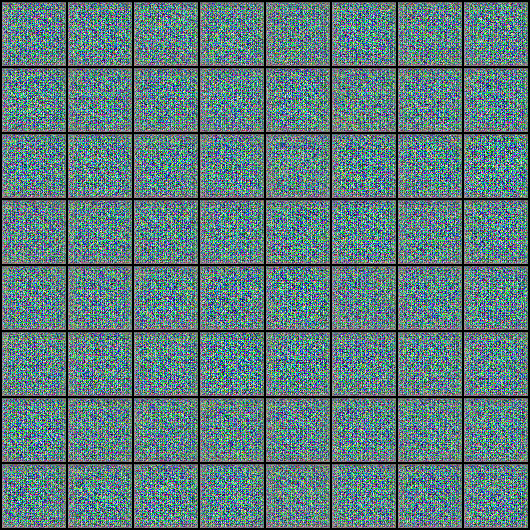

Displaying image: /kaggle/working/images/generatedPokemon-images-0050.png


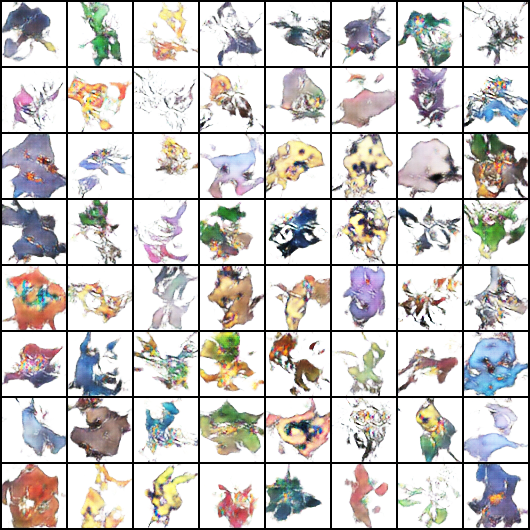

Displaying image: /kaggle/working/images/generatedPokemon-images-0100.png


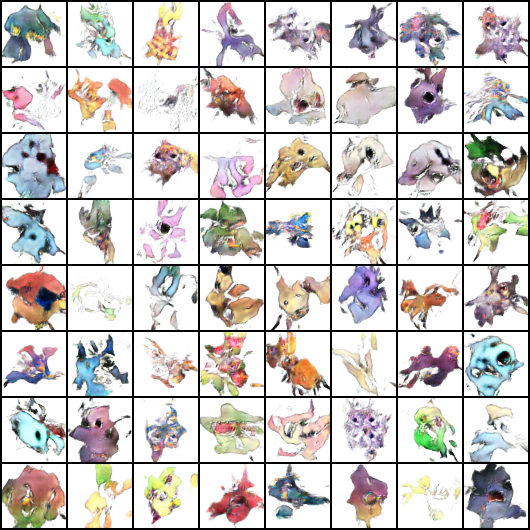

Displaying image: /kaggle/working/images/generatedPokemon-images-0150.png


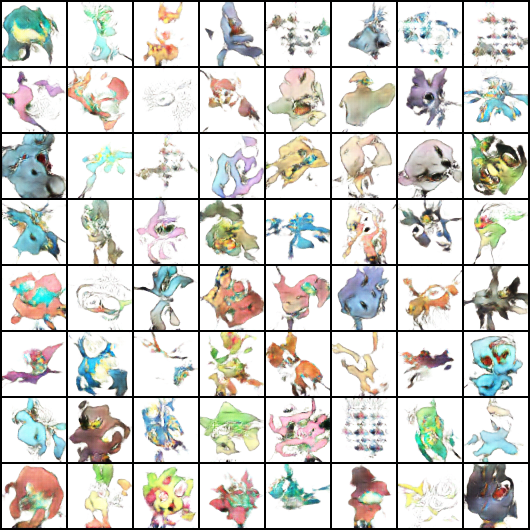

Displaying image: /kaggle/working/images/generatedPokemon-images-0200.png


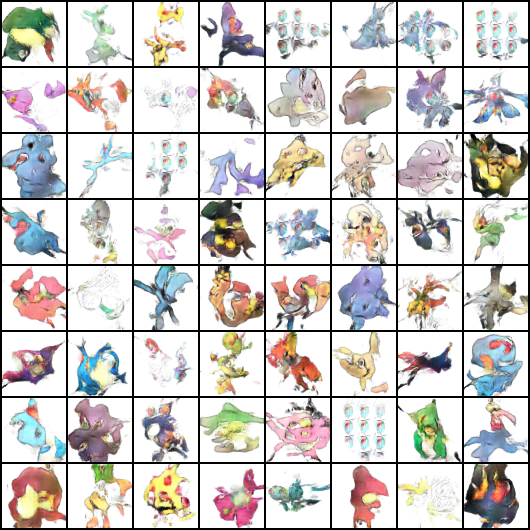

Displaying image: /kaggle/working/images/generatedPokemon-images-0250.png


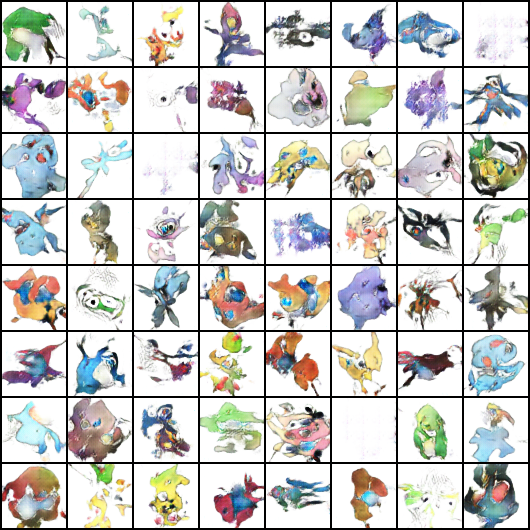

Displaying image: /kaggle/working/images/generatedPokemon-images-0300.png


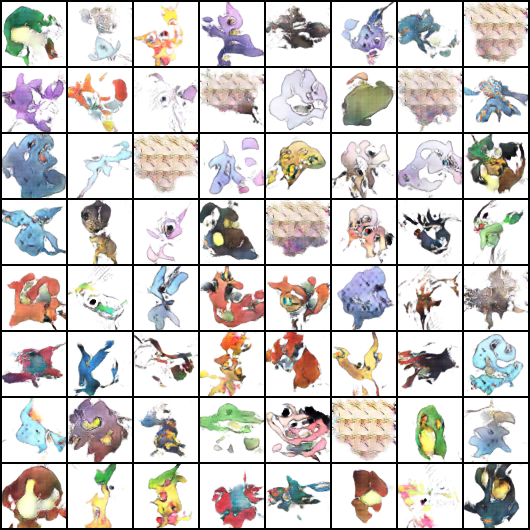

Displaying image: /kaggle/working/images/generatedPokemon-images-0350.png


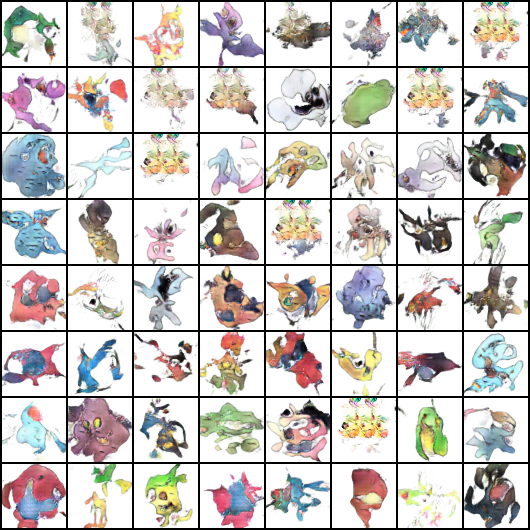

Displaying image: /kaggle/working/images/generatedPokemon-images-0400.png


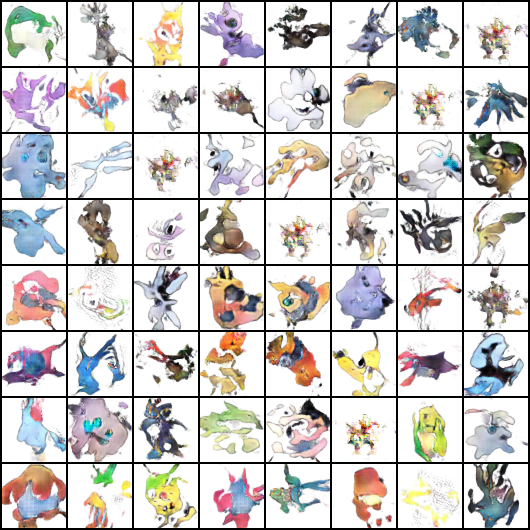

In [91]:
base_filename = "generatedPokemon-images-{:04d}.png"

from IPython.display import display
from PIL import Image

# Loop through filenames, incrementing by 50
for i in range(0, 450, 50):  # Adjust the range as needed
    # Construct the full image path
    image_path = os.path.join(image_dir, base_filename.format(i))

    # Check if the image exists
    if os.path.exists(image_path):
        # Open and display the image
        image = Image.open(image_path)
        print(f"Displaying image: {image_path}")
        display(image)  # Display the image in the notebook
    else:
        print(f"Image not found: {image_path}")

### Visualisations

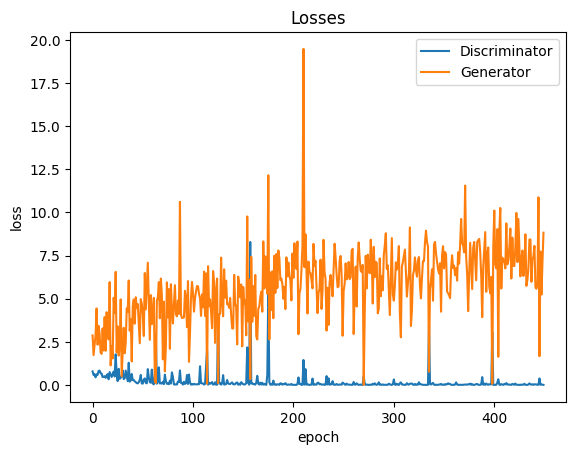

In [92]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

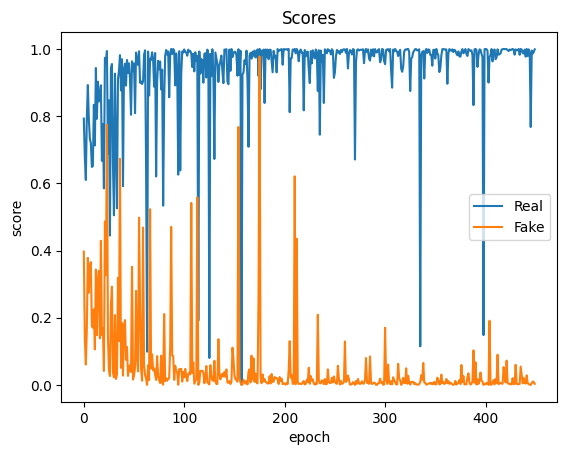

In [93]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

Real Images
Fake Images


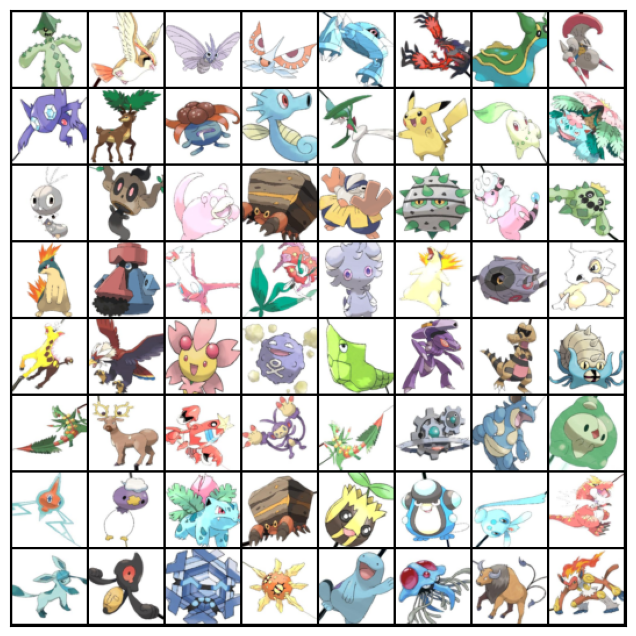

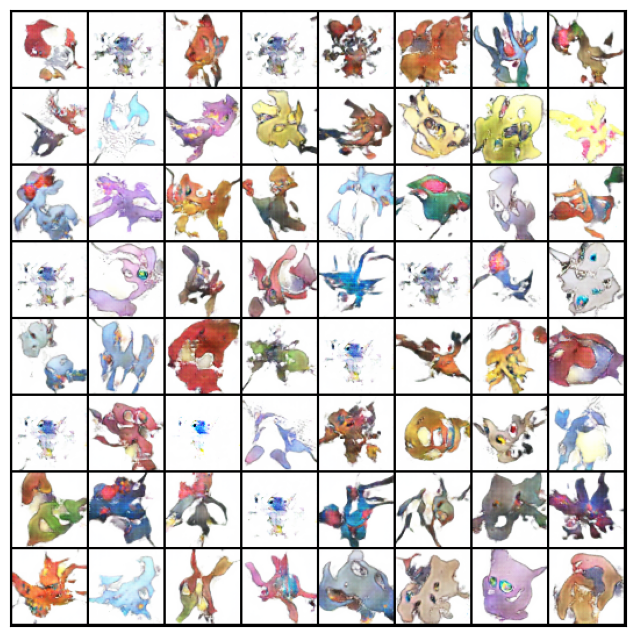

In [95]:
real_images, _ = next(iter(train_dataloader))

with torch.no_grad():
    latent = torch.randn(batch_size, latent_dim, 1, 1, device=device)
    fake_images = generator(latent)

# showcase the real image
print("Real Images")
show_images(real_images.cpu())

# compare with fake image
print("Fake Images")
show_images(fake_images.cpu())


## showing individual images generation

### saving the generator

In [100]:
# Save the generator's state dictionary
filename = "450epochPokemonDCGAN"
checkpoint_path = os.path.join(checkpoint_dir, filename)
torch.save(generator.state_dict(), checkpoint_path)
print(f"Generator saved to {checkpoint_path}")

Generator saved to /kaggle/working/checkpoints/450epochPokemonDCGAN


In [101]:
torch.save(generator.state_dict(), os.path.join(save_dir, 'pokeDcGan.pth'))